In [1]:
import logging
logging.basicConfig(level=logging.WARNING)

import os
import json
import hoomd
import codecs
import cooltools

import gsd.hoomd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import polychrom_hoomd.log as log
import polychrom_hoomd.utils as utils
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude

from lattice_translocators.generators.Translocator import Translocator
from lattice_translocators.engines.MultistateSymmetricExtruder import MultistateSymmetricExtruder

from polykit.analysis import contact_maps
from polykit.generators.initial_conformations import grow_cubic

from matplotlib.colors import LogNorm, LinearSegmentedColormap

In [2]:
# Initialise HOOMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0]           NVIDIA L40S 142 SM_8.9 @ 2.52 GHz, 45596 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 12785


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate a singe chromosome comprised of 200,000 monomers, with number density 0.2
density = 0.2
chromosome_sizes = [200000]

In [6]:
# Setup chromosome within a cubic box of length L
number_of_monomers = sum(chromosome_sizes)
L = (number_of_monomers/density)**(1/3.)

In [7]:
# Set corresponding periodic simulation box
snapshot = build.get_simulation_box(box_length=L, pad=0.)

In [8]:
# Build random, dense initial conformations
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L))

In [9]:
# Parse force parameters
with open("force_dict_multistate.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

In [10]:
# Parse particle/bond types
bond_types = force_dict['Bonded forces'].keys()
angle_types = force_dict['Angular forces'].keys()
monomer_types = force_dict['Non-bonded forces']['Repulsion']['Matrix'].keys()

In [11]:
# Populate snapshot with the generated chains
build.set_chromosomes(snapshot, monomer_positions, chromosome_sizes,
                      bond_type_list=list(bond_types), monomer_type_list=list(monomer_types),
                      angle_type_list=list(angle_types))

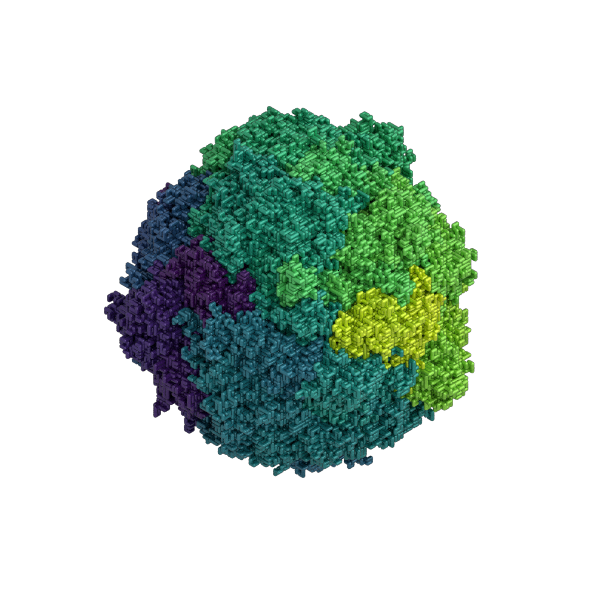

In [12]:
# Render initial conformation using the Fresnel backend
render.fresnel(snapshot, intensity=0.5).static()

In [13]:
# Parse extrusion parameters
with open("extrusion_dict_multistate.json", 'r') as dict_file:
    extrusion_dict = json.load(dict_file)

In [14]:
# Setup simulation without CTCF barriers
ctcf_left_positions = []
ctcf_right_positions = []

In [15]:
# Create translocator object
translocator = Translocator(MultistateSymmetricExtruder, 
                            snapshot.particles.types,
                            snapshot.particles.typeid,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **extrusion_dict)

In [16]:
# Precompute lattice extruder positions in 1D
translocator.run()

In [17]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [18]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [19]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [20]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [21]:
# Set attractive/DPD forces
dpd_forces = forces.get_dpd_forces(nl, **force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict) # DPD with custom conservative force field requires a dummy attractive force for proper equilibration

Setting up DPD with the conservative force contribution disabled


In [22]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces \
            + dpd_forces + attraction_forces

In [23]:
# Setup DPD integrator
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home1/tortora/.conda/envs/multistate/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [24]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [25]:
trajectory_length = 100
trajectory_name = 'trajectory_multistate.gsd'

period = extrusion_dict['steps']*extrusion_dict['3D_to_1D_steps'] // trajectory_length

In [26]:
# Setup output trajectory in .gsd format
gsd_writer = hoomd.write.GSD(filename=trajectory_name,
                             trigger=hoomd.trigger.Periodic(period),
                             dynamic=['topology'],
                             mode='wb')

system.operations.writers.append(gsd_writer)

In [ ]:
# Run MD simulation
for lef_positions in translocator.lef_trajectory:
    extrude.update_topology(system, lef_positions, thermalize=False)    
    system.run(extrusion_dict['3D_to_1D_steps'])

notice(3): GSD: create or overwrite gsd file trajectory_multistate.gsd
Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           631.84178         0:00:00               1.38385          
       20000           661.58477         0:00:00               1.75725          
       30000           669.62665         0:00:00               1.91181          
       40000           665.64192         0:00:00               1.92300          
       50000           675.47772         0:00:00               1.87311          
       60000           674.21207         0:00:00               1.78637          
       70000           672.40779         0:00:00               1.71678          
       80000           676.49072         0:00:00               1.67789          
       90000           673.26593         0:00:00               1.63937          
      100000           667.19900         0:00:00               1.61322          
      110000           665.95346      

In [ ]:
# Visualize final conformation
final_snapshot = system.state.get_snapshot()

render.fresnel(final_snapshot, intensity=0.5).static()

In [ ]:
# Visualize individual extruder positions
render.fresnel(final_snapshot, rescale_backbone_bonds=0.05, intensity=0.5).static()

In [ ]:
# Set extruder colormap
colors = [(25./255, 25./255, 25./255), # Non-cohesin bonds (grey)
          (59./255, 117./255, 175./255), # NIPBL-bound cohesin
          (221./255, 124./255, 56./255), # bare bound cohesin
          (81./255, 158./255, 62./255), # PDS-bound cohesin
          (141./255, 105./255, 184./255)] # WAPL-bound cohesin

cmap = LinearSegmentedColormap.from_list("cohesin_states", colors, N=5)

mpl.colormaps.register(cmap)

In [ ]:
# Get final cohesin states
final_LEF_states = translocator.state_trajectory[-1]

In [ ]:
# Get bound cohesins
final_bound_LEFs = final_LEF_states > 0

bound_LEF_num = np.count_nonzero(final_bound_LEFs)

In [ ]:
# Color bound cohesins based on chemical state
color_array = np.zeros(final_snapshot.bonds.N, dtype=np.uint32)

color_array[-bound_LEF_num:] = final_LEF_states[final_bound_LEFs]

In [ ]:
# Visualize individual extruder states
render.fresnel(final_snapshot, rescale_backbone_bonds=0.05, color_array=color_array, cmap='cohesin_states', intensity=0.5).static()

In [ ]:
def load_gsd(filename):
    fname, group = filename.split("::")

    with gsd.hoomd.open(name=fname, mode="r") as traj:
        snapshot = traj[int(group)]
        
        return utils.unwrap_coordinates(snapshot)

In [ ]:
# Compute contact map within subchains of length 1000 monomers
map_size = 1000
map_starts = np.arange(0, number_of_monomers, map_size)

In [ ]:
URIs = [trajectory_name + "::%d" % i for i in range(trajectory_length)]

In [ ]:
mrc = contact_maps.monomerResolutionContactMapSubchains(
                URIs,
                load_gsd,
                map_starts,
                map_size,
                cutoff=2.3,
                n=32)

In [ ]:
plt.imshow(mrc, norm=LogNorm())

In [ ]:
# Turn dense contact map into sparse .cool
clr = contact_maps.coolify(mrc, 'contact_matrix')
view_df = cooltools.lib.make_cooler_view(clr)

In [ ]:
# Compute contacts vs. distance curve via cooltools (https://cooltools.readthedocs.io/en/latest/notebooks/contacts_vs_distance.html)
cvd = cooltools.expected_cis(
    clr=clr,
    view_df=view_df,
    smooth=True,
    aggregate_smoothed=True,
    nproc=32
)

dist, ps = cvd['dist'], cvd['balanced.avg.smoothed.agg']
ps.loc[dist < 2] = np.nan

In [ ]:
plt.loglog(dist, ps)

plt.xlabel(r'$d$ (monomers)')
plt.ylabel('Contact frequency')

plt.grid(True)